In [12]:
%load_ext autoreload
%autoreload 2

# 02B-Fashion-MNIST-larger-example

In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

[Fashion MNIST Github Repo](https://github.com/zalandoresearch/fashion-mnist)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

**Problem** - Given a grayscale image of fashion items predict the class from 10 different classes. Since each image contains only one item, it is a **multiclass-classification problem**.


Type of classification problems:
* Binary - Predict between two mutually exclusive outcomes. (spam or not spam; rain or no rain; positive sentiment or negative sentiment)
* Multiclass - Predict between n mutually exclusive outcomes. (above problem; sunny, rainy, windy;)
* Multilabel - Predict between n outcomes each of which can happen simultaneously (object detection in natural setting images; tags of a webpage/article)

In [14]:
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print(f'Number of classes: {n_classes}')

Number of classes: 10


In [15]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [16]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**Note**:

* We have 60000 images in training set and 10000 in test set
* The dimension of the image is 28x28 (grayscale, all same dimensions)
* The labels are integer values from 0-9, with mapping in class_names


### Comparing train and test set label distribution


In [40]:
from src.utils import LabelAnalyzer

In [41]:
set.symmetric_difference(set(np.unique(train_labels)), set(np.unique(test_labels)))

set()

All classes are present in both train and test sets

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='name'>

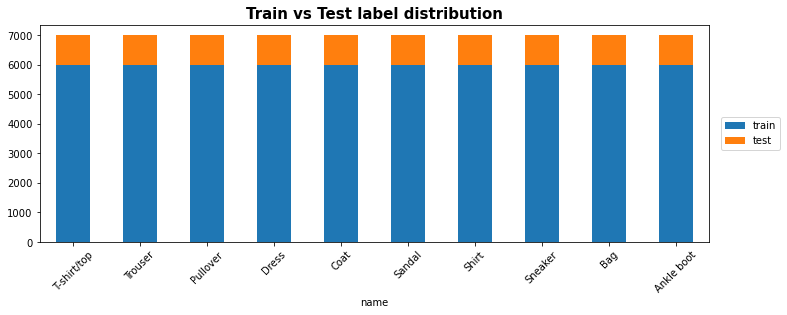

In [43]:
la = LabelAnalyzer(train_labels, test_labels, classes=class_names)
la.plot()

In [44]:
la = LabelAnalyzer(train_labels, test_labels, classes=None)


The distribution is uniform in both with classes equally distributed between themselves as well as between train and test sets! :)

#### Analyzing distribution of classes in a batch of 32

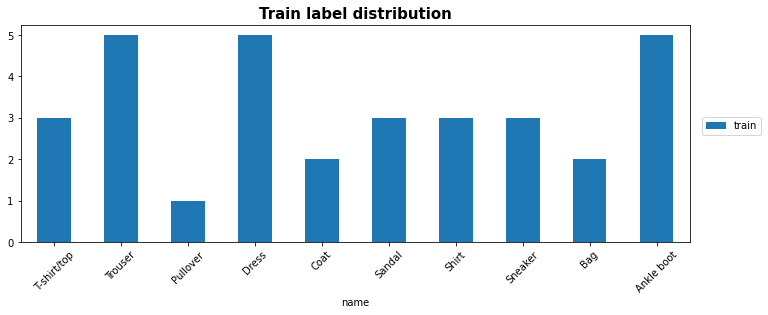

In [45]:
idx = np.random.randint(0, len(train_labels), 32)
la_batch = LabelAnalyzer(train_labels[idx], test_labels=None, classes=dict(zip(range(0, 10), class_names)))
la_batch.plot();

## Viewing an example image

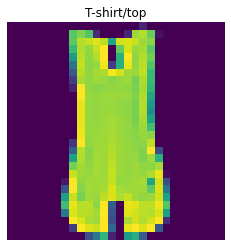

In [46]:
idx = np.random.choice(la.countdf['label'])
img = plt.imshow(train_images[idx])
plt.title(class_names[train_labels[idx]]);
img.axes.set_axis_off()

In [47]:
from matplotlib.gridspec import GridSpec
import copy

In [93]:
from src import ImageDataset

## Create the `ImageDataset`

In [94]:
imgds = ImageDataset((train_images, train_labels), (test_images, test_labels), class_names)

### Plot the label counts

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='name'>

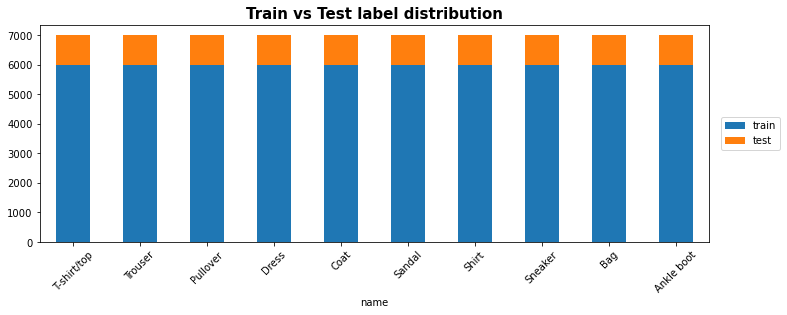

In [95]:
imgds.plot_labelcounts()

### View Random images

#### train

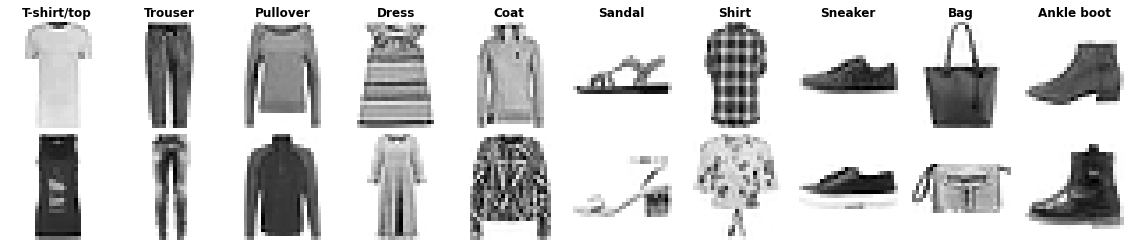

In [98]:
axn = imgds.view_random_images(class_names='all', n_each=2, subset='train')

#### test

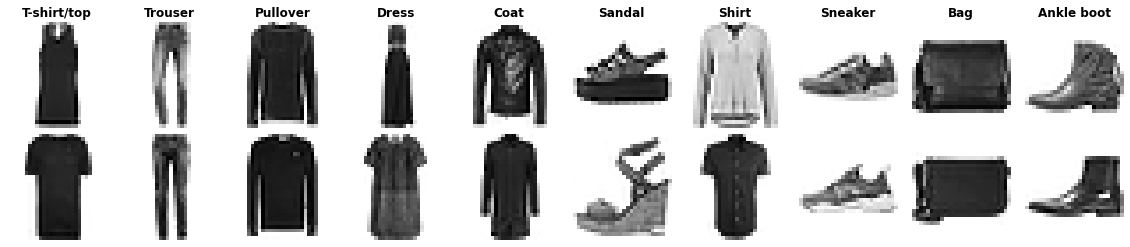

In [84]:
axn = imgds.view_random_images(class_names='all', n_each=2, subset='test')

### Now select a few classes

* Suppose you want to make separate models for different groups of classes (which appear visually very similar) and then combine their predictions

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='name'>

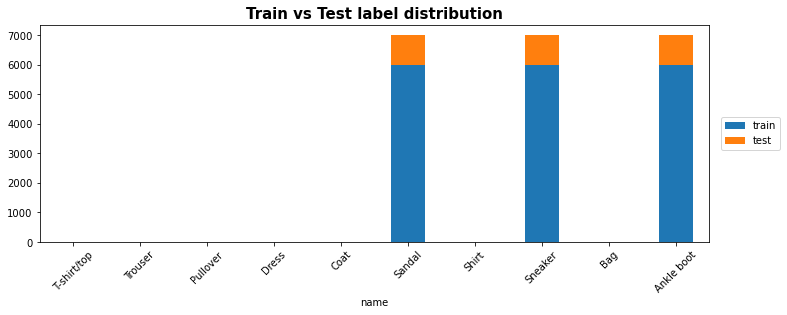

In [100]:
imgds_shoes = imgds.select(class_names=['Sandal', 'Sneaker', 'Ankle boot'])
imgds_shoes.plot_labelcounts()

## Build a multiclass classification model

* Loss function = `CategoricalCrossentropy` (if one-hot) else `SparseCategoricalCrossentropy`
* Output activation = `Softmax`
* Input shape = 28x28 (shape of one image)
* Output shape = 10 (1 per class)

In [86]:
from tensorflow.keras import layers, losses, optimizers
from src.utils import plot_keras_model
from src.visualize import plot_confusion_matrix, plot_learning_curve
from sklearn.metrics import classification_report
from src.keras_metrics import KerasMetrics

### Get one hot encoded labels

In [87]:
y_train, y_test = imgds.get_one_hot_labels('train'), imgds.get_one_hot_labels('test')

### Scale the images

* The images are 8bit single channel images (Hence the pixel values are intensities between $0$ and $2^8 - 1 = 255$

In [88]:
print('train:' , imgds.train_images.min(), imgds.train_images.max())
print('test:' , imgds.test_images.min(), imgds.test_images.max())

train: 0 255
test: 0 255


In [89]:
X_train, X_test = imgds.train_images/255.0, imgds.test_images/255.0

In [90]:
print('train:' , X_train.min(), X_train.max())
print('test:' , X_test.min(), X_test.max())

train: 0.0 1.0
test: 0.0 1.0


### The `Flatten` layer

* Before passing the images of dim (28, 28) into a simple Deep Neural Network, we need to flatten the images
* Then we can construct the Neural Network layers as usual
* This makes it loose the spatial correlation property, and model now has no hints whatsoever that some pixels are spatially closer to one another. 

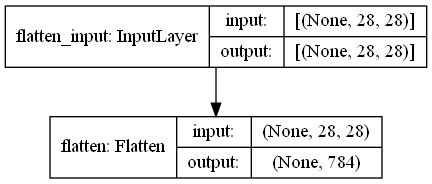

In [91]:
flatten_model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=(imgds.train_dim))
])

plot_keras_model(flatten_model, show_shapes=True)

The flatten layer flattens a (28, 28) into 784 (1-D) vector

In [92]:
X_train.shape, flatten_model.predict(X_train).shape

((60000, 28, 28), (60000, 784))

## `tfmodels`

* A dictionary to hold all the models we create

In [128]:
tfmodels = {}

## Model 1: Simple Deep Neural Network 

In [173]:
# Set random seed
tf.random.set_seed(42)

# Create model
model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=imgds.train_dim),
    layers.Dense(4, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(imgds.n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), metrics=[KerasMetrics.f1])


In [174]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_50 (Dense)             (None, 10)                50        
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


In [177]:
# Fit the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=0) # 128 batch size works faster!
tfmodels['simple-dense-2layer'] = model

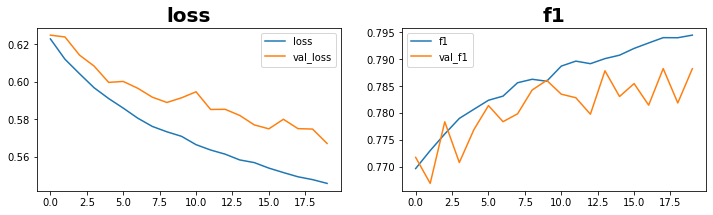

In [178]:
plot_learning_curve(history.history, extra_metric='f1');

Seems like the model has stopped learning more patterns, and seems underfitted. Maybe if we increase the number of neurons in each layer.

## Model 2: Simple Deep Neural Network - 2layer - larger

In [207]:
# set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=imgds.train_dim),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(imgds.n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(1e-3), metrics=[KerasMetrics.f1])

In [208]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 6280      
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_56 (Dense)             (None, 10)                90        
Total params: 6,442
Trainable params: 6,442
Non-trainable params: 0
_________________________________________________________________


In [181]:
# Fit the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=0)
tfmodels['medium-dense-2layer'] = model

### Plot learning curve

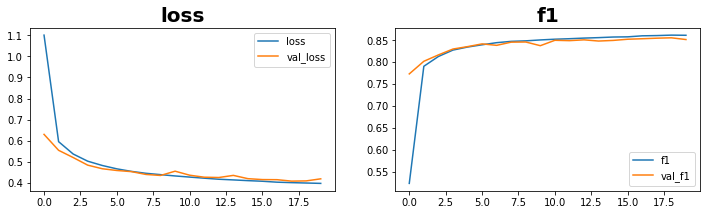

In [172]:
plot_learning_curve(history.history, extra_metric='f1');

Our model definitely improved with addition of more neurons and it doesn't seem to overfit!

### Effect of normalization

In [206]:
model = tf.keras.models.clone_model(model)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), metrics=[KerasMetrics.f1]) 

history_non_norm = model.fit(imgds.train_images, y_train, validation_split=0.1, batch_size=128, epochs=20, verbose=0)
history_norm = model.fit(imgds.train_images/255.0, y_train, validation_split=0.1, batch_size=128, epochs=20, verbose=0)

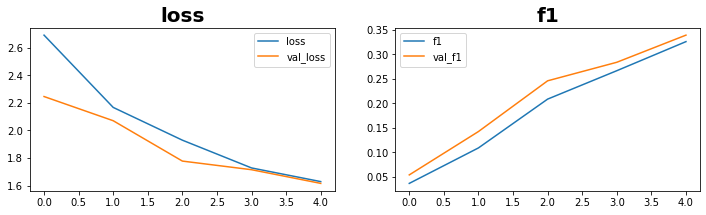

In [201]:
plot_learning_curve(history_non_norm.history, extra_metric='f1');

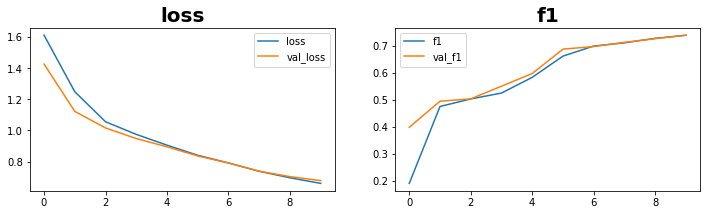

In [205]:
plot_learning_curve(history_norm.history, extra_metric='f1');

We see a definite improvement after scaling the input features!

## Model 3: CNN Model

In [409]:
# Set random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    layers.Input(shape=imgds.train_dim),
    layers.Lambda(lambda x: tf.expand_dims(x, -1)),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(imgds.n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=1e-3), metrics=[KerasMetrics.f1])

# Summary
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 10)        910       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 10)          0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 490)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)              

In [389]:
# Fit the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=0)
tfmodels['cnn'] = model

### Plot learning curve

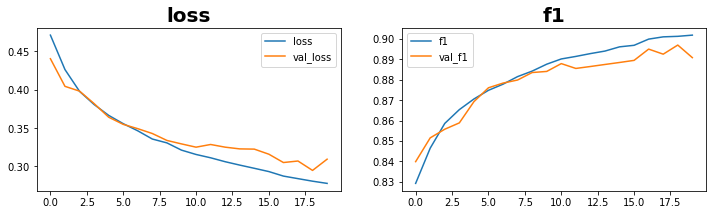

In [390]:
plot_learning_curve(history.history, extra_metric='f1');

Even though we have achieved a really good performance, seems like we are not decreasing loss as fast as we could! We can finding a better learning rate

## Model 4: CNN Model - better learning rate

### Finding the ideal learning rate

* Using a `LearningRateScheduler` we vary the learning_rate with epoch
* Slowly increasing it from 1e-3 to 1e-2 in logspace

#### Making the `LearningRateScheduler`

In [394]:
from tensorflow.keras import callbacks

num_epochs = 20
lr_epochvals = np.logspace(-4, -2, num_epochs)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: lr_epochvals[epoch])

#### Fitting the model (smaller sample)

In [410]:
model = tf.keras.models.clone_model(model)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam())
sample_size = 10000
history_lr = model.fit(np.expand_dims(X_train, -1)[:sample_size], y_train[:sample_size], batch_size=128, epochs=num_epochs, callbacks=[lr_scheduler], verbose=0)

#### Learning rate vs epoch plot

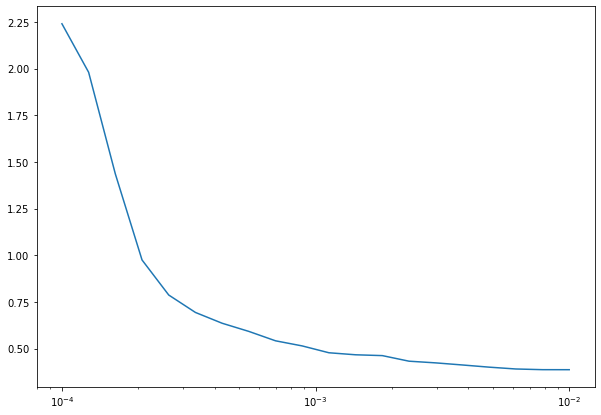

In [412]:
history_lr_df = pd.DataFrame(history_lr.history)

plt.figure(figsize=(10, 7))
plt.semilogx(history_lr_df['lr'], history_lr_df['loss'])

* The loss is decreasing fastest somewhere between $10^{-4}$, and first xtick after.


In [413]:
best_lr = 1e-4 + (1e-4)*1/2
best_lr

0.00015000000000000001

### Refit the model with ideal learning_rate

In [414]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=best_lr), metrics=[KerasMetrics.f1])
history = model.fit(X_train,  y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=0)
tfmodels['cnn-best_lr'] = model

### Plot the learning curve

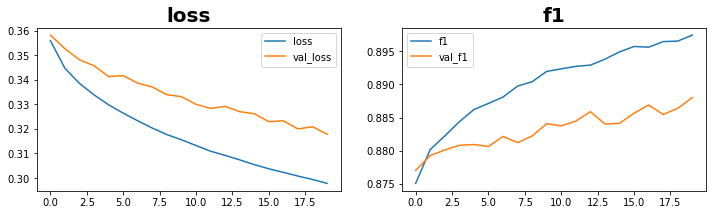

In [415]:
plot_learning_curve(history.history, extra_metric='f1');

The overfitting seems amplified because of the scale, but the model has performed better than the previous model (or maybe not! Changes on each run!)

### Evaluate the predictions

#### Predictions

* Generally the class with the highest probability is the predicted class (Maybe you can set different thresholds for each class)

In [416]:
y_pred_prob_test = tfmodels['cnn-best_lr'].predict(np.expand_dims(X_test, -1))
y_pred_test = y_pred_prob_test.argmax(axis=1)

#### Confusion matrix

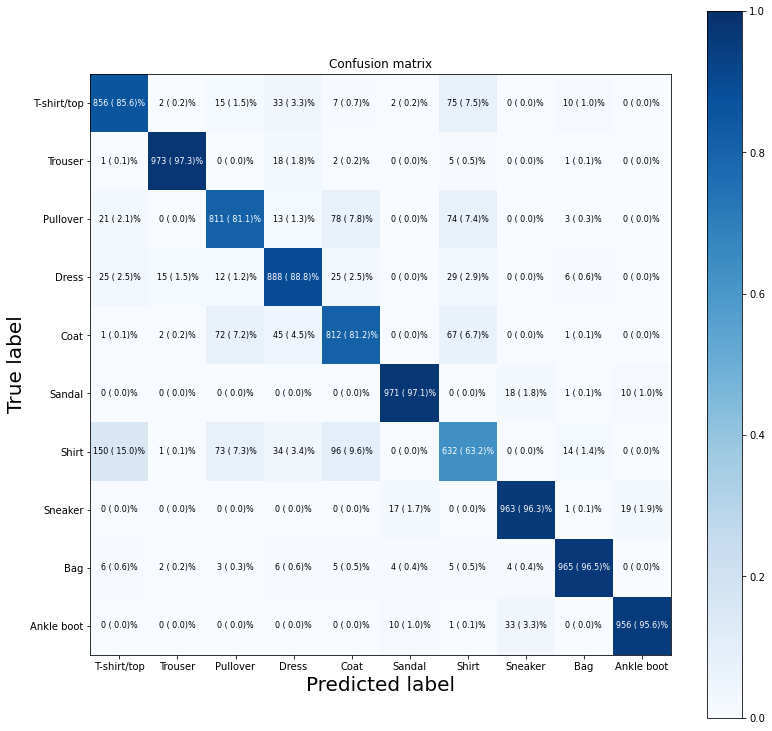

In [418]:
ax = plot_confusion_matrix(imgds.test_labels, y_pred_test, classes=imgds.class_labels, figsize=(13, 13), text_size=8)

#### Classification metrics

In [403]:
print(classification_report(imgds.test_labels, y_pred_test, target_names=imgds.class_labels, output_dict=False))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.82      0.81      0.82      1000
       Dress       0.86      0.88      0.87      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.71      0.63      0.67      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Comparing models

In [438]:
compdf = []
for name, model in tfmodels.items():
    y_pred_prob_test = model.predict(X_test)
    y_pred_test = y_pred_prob_test.argmax(axis=1)
    crdf = pd.DataFrame(classification_report(imgds.test_labels, y_pred_test, target_names=imgds.class_labels, output_dict=True))
    crdf['model'] = name
    
    compdf.append(crdf)
    
    
compdf = pd.concat(compdf)
compdf.index.name = 'metric'
compdf.reset_index(inplace=True)
# compdf = compdf.set_index(['metric', 'model']).sort_index()

In [444]:
compdf.head()

,metric,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot,accuracy,macro avg,weighted avg,model
0,precision,0.742802,0.958678,0.692308,0.776047,0.594384,0.920732,0.450626,0.904483,0.922167,0.930162,0.7931,0.789239,0.789239,simple-dense-2layer
1,recall,0.774000,0.928000,0.657000,0.797000,0.762000,0.906000,0.324000,0.928000,0.936000,0.919000,0.7931,0.793100,0.793100,simple-dense-2layer
2,f1-score,0.758080,0.943089,0.674192,0.786384,0.667835,0.913306,0.376963,0.916091,0.929032,0.924547,0.7931,0.788952,0.788952,simple-dense-2layer
3,support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.7931,10000.000000,10000.000000,simple-dense-2layer
4,precision,0.768089,0.979339,0.796368,0.818354,0.729287,0.953799,0.579380,0.914894,0.945289,0.952859,0.8405,0.843766,0.843766,medium-dense-2layer


In [445]:
import seaborn as sns

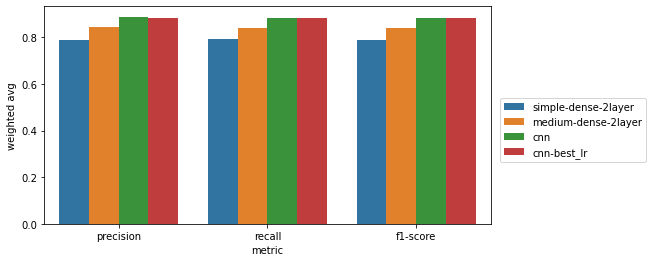

In [456]:
plt.figure(figsize=(8, 4))
sns.barplot(x='metric', y='weighted avg', hue='model', data=compdf[compdf['metric'] != 'support'])
plt.legend(bbox_to_anchor=[1.01, 0.6])

## Viewing predictions of the model

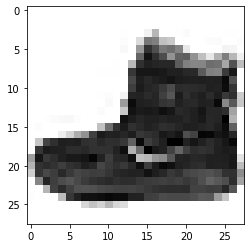

In [459]:
fig, ax = plt.subplots()
idx = np.random.
ax.imshow(X_train[0, :, :], cmap=plt.cm.binary)

In [491]:
def view_random_prediction(model, images, true_labels, class_names):
    
    # Sample a random integer
    idx = np.random.randint(0, len(images))
    
    
    # Get prediction
    target_image = images[idx]
    pred_probs = np.squeeze(model.predict(np.expand_dims(target_image, 0)))
    
    idxmax = pred_probs.argmax()
    prob = pred_probs[idxmax]
    pred_label = class_names[idxmax]
    

    
    # Get true label
    true_label = class_names[idxmax]
    
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # Plot it
    plt.imshow(target_image, cmap=plt.cm.binary)
    plt.title(f'{pred_label} ({prob*100: .2f}%)', color=color, size=15)
    plt.xlabel(true_label, fontdict=dict(weight='bold', size=15))
    
    

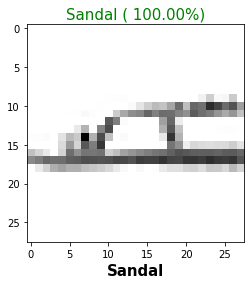

In [548]:
view_random_prediction(tfmodels['cnn-best_lr'], imgds.test_images, imgds.test_labels, imgds.class_labels)